# Starbucks Capstone Challenge 

### Project Overview


This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

#### Business Questions

In my capstone project, I aim to answer following 2 business questions:

1. What proportions of the users complete the offers based on their age and gender
2. What kind of offers should be sent more to the users.

#### Data

The data provided consists of 3 datasets:

1. Offer portfolio, which consists of the attributes of each offer (portfolio.json)
2. Demographic data for each customer (profile.json)
3. Transactional records of events occurring on the app (transcript.json)



### Data Sets

The data is contained in the following 3 files with their respective schemas

#### portfolio.json
This data set contains the user attributes. The schema of the dataset is as follows:
- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

#### profile.json
This data set contains the demographic area details, how different areas get different offers. It contains two of the most important features to answer our first business question, age and gender. We might explore the income affecting the offers as well. The schema for the dataset is as follows:
- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

#### transcript.json
This data set contains the transactional records for the various users and offers availed over the app. The schema is as follows:
- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

### Contents and Flow

- Importing libraries and loading data
- Data Exploration
- Data Cleaning
- Data Analysis
- Applying Random Forest classifier on the data

## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
import datetime

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

After loading the data in the respective datasets, exploring the various features and how data is distributed across the various datasets.

Starting with initially portfolio dataset and then proceeding with profile and transcript dataframes

In [2]:
portfolio.shape, transcript.shape, profile.shape

((10, 6), (306534, 4), (17000, 5))

Exploring the portfolio dataset first

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


This dataset contains the type of offers the user receives. Lets check for the different counts of the offers user receives over the app.

We need to check for what type of offers are received by the users and then can be used to apply classifications.

In [4]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [5]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

The user receives mostly BOGO (buy one get one) and discounted offers, followed by informational offers, which are in less quantity.

These are the main offers which users have received in the starbucks app.

In [6]:
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Since no null values exist in the dataset, no need to impute any values at all.

After portfolio, **exploring the profile dataset**

In [7]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


The data set contains three of the critical charateristics, age, gender and income.

These 3 are useful as we might be able to find a pattern on which user characteristic is more inclined to avail the available offer and can send them such types of offers more frequently than other offer types.

In [8]:
#Checking for any null values in the dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

A lot of null values exist in the data set for gender and income.
They contain the same number of null values, it could be the case where same corresponding entries have the null values.
We need to explore data further to make sure whether these rows can be dropped or are they going to impact our analysis and the model

Text(0.5,0,'Gender')

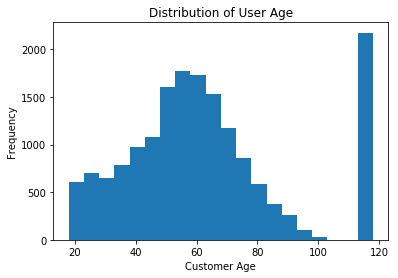

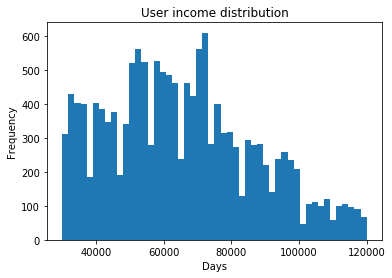

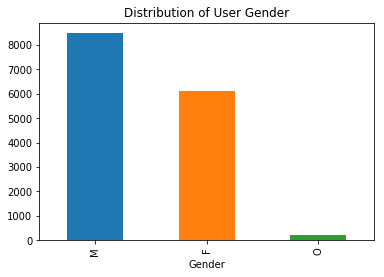

In [9]:
#checking age, income and gender distributions across the users
#Distribution of age
user_age = profile['age'].plot(kind='hist', bins=20, title='Distribution of User Age')
user_age.set_xlabel("Customer Age")
       
#Distribution of income
plt.figure()
user_income = profile['income'].plot(kind='hist', bins=50, title='User income distribution')
user_income.set_xlabel("Days")
    
# Display Histogram of User Income
plt.figure()
user_gender = profile['gender'].value_counts().plot.bar(title='Distribution of User Gender')
user_gender.set_xlabel("Gender")

Age=118 isn't making any sense, as it is clearly out of the normal distribution.
It is clearly showing as an outlier.

Checking what kind of values exist for age = 118

In [10]:
#checking count of age=118 value and corresponding gender and income columns
profile[profile['age']==118].count()


age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

The null values we encountered earlier for gender and income exist only for age=118 data entries. 
The values corresponds to exactly the same number of values for which the gender and income have null values in the dataset.
Since, age=118 doesn't make any sense and hence dropping the entries from the dataframe.

In [11]:
#redefining the profile dataframe by dropping null values and age being 118
profile = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)

Text(0.5,0,'Customer Age')

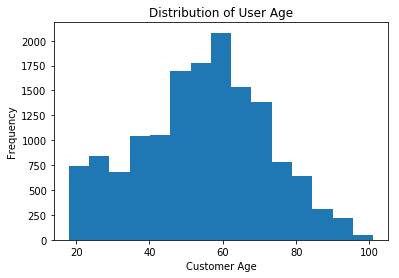

In [12]:
user_age = profile['age'].plot(kind='hist', bins=15, title='Distribution of User Age')
user_age.set_xlabel("Customer Age")

No more unexpected values of ages over 100 as that are clearly outliers (bad data) in our dataset.

In [13]:
#checking if there are still any null values in data set after deleting all the age=118 data values
profile.isna().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

####  Transactional Records

In [14]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [16]:
#checking number of unique people represented, giving us the total user count
transcript['person'].nunique()

17000

The data shows there are 17k unique users for which we have the data for.
Checking further if the dataset contains any null values.

In [17]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values in this data.



In [18]:
#further info for the dataset
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


### Data Cleaning 

Before we move to making analysis and predictions about our business questions posed above, we need to clean the data, so as to make our  job easier for the process.

Cleaning the 3 datasets for pre-processing and analyzing data to answer the business questions.

In [19]:
#firstly proceeding with portfolio dataset
def clean_portfolio(df=portfolio):
    """
    Takes the dataframe portfolio and cleans it by creating one-hot encodings.
    
    PARAMETERS:
        portfolio dataframe
        
    RETURNS:
        A new dataframe consisting of:
        ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    """
    
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    

    # https://stackoverflow.com/questions/18889588/create-dummies-from-column-with-multiple-values-in-pandas
    channels = cleaned_portfolio["channels"].str.join(sep="*").str.get_dummies(sep="*")
    
    #offer_type column (BOGO, discount, informational)
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    #concatinating the offer types and the channels to the df(portfolio)
    new_df = pd.concat([df, channels, offer_type], axis=1, sort=False)
    
    # Remove channels and offer_type as we don't specifically need these, can always add them later
    new_df = new_df.drop(['channels', 'offer_type'], axis=1)
    
    # Organize columns
    columns = ["id", "difficulty", "duration", "reward", "email", "mobile", "social", "web", "bogo", "discount", "informational"]
    new_df = new_df[columns]
    
    
    return new_df

In [20]:
#retrieving cleaned dataset after running the above created function
cleaned_portfolio = clean_portfolio() 
cleaned_portfolio.head(5)

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0


Here we have created dummy columns from existing columns to make the representation easier for us.

**Proceeding with profile dataset**

In [96]:
profile.head(5)

,age,became_member_on,gender,id,income
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [21]:
#cleaning the profile dataset
def clean_profile(profile = profile):
    """ 
    inpur:
        Profile dataframe.
        
    returns:
        A new dataframe that has dummy column as per our requirement
    """
    #already deleted the age=118 entries, so no need to delete 
    
    #One-hot encode Gender column, creating dummy variables for various genders listed
    gender_dummies = pd.get_dummies(profile["gender"])
    
    # Specifying age range and one hot encoding, creating the age groups
    range_ages = pd.cut(x=profile["age"], bins=[17,20, 29, 39, 49, 59, 69, 79, 89, 99])
    
    #Creating dummy columns for the age groups created above
    ages_dummies = pd.get_dummies(range_ages)
    
    #Creating the incomce bins and creating dummy columns based on the age income slabs created
    range_income = pd.cut(x=profile["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    

    #adding the dummy columns created to profile dataframe
    new_df = pd.concat([profile, ages_dummies, income_dummies, gender_dummies], axis=1, sort=False)
    
    # Dropping age,gender,income column, as we have already created dummy columns for the same
    new_df = new_df.drop(["age", "gender", "income"], axis=1)

    
    return new_df

In [22]:
#retrieving cleaned data from profile dataframe
cleaned_profile = clean_profile() 
cleaned_profile.head(5)

,became_member_on,id,"(17, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,20170715,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,20170509,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,20180426,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,20180209,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,20171111,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


creating the plots for cleaned profile dataset for better understanding.

Added visualizations below to have better understanding of the dummy columns that have been added

Text(0.5,17.2,'Gender')

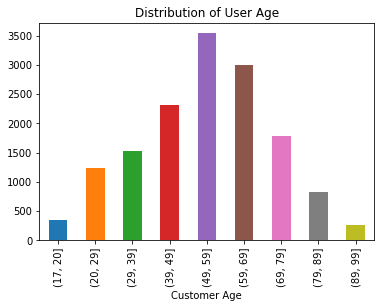

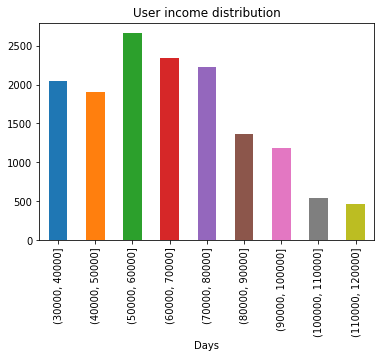

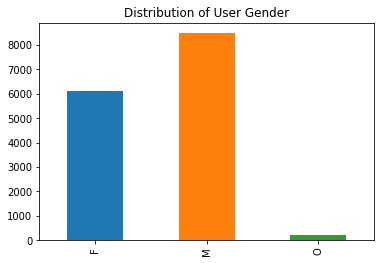

In [23]:
#checking age, income and gender distributions across the users on the cleaned profile dataset
user_age = cleaned_profile[cleaned_profile.columns[2:11]].sum().plot.bar( title='Distribution of User Age')
user_age.set_xlabel("Customer Age")
       
#Distribution of income
plt.figure()
user_income = cleaned_profile[cleaned_profile.columns[11:20]].sum().plot.bar(title='User income distribution')
user_income.set_xlabel("Days")
    
# Display Histogram of User Income
plt.figure()
user_gegder = cleaned_profile[cleaned_profile.columns[20:]].sum().plot.bar(title='Distribution of User Gender')
user_gender.set_xlabel("Gender")

Profile data set is cleaned and retrieved, with required classifications done for age, gender and income for the users.

**Proceeding with cleaning the transcript Dataset**

In [24]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


Since the value contains all the offer id's. We need to write a function which separates the offer id's as a column rather than value.
Then it would be clear for us to work on the data as well.

In [25]:
# Functions to create offer id and amount columns from the transcript table
#this is required as there are no offer id or anything they are set up un a value column
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]

In [26]:
#function to clean the transcript
def clean_transcript(transcript = transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
        transcript - the transcript dataframe to be cleaned
    
    returns:
        offer - the cleaned offer dataframe
    '''
    #creating cleaned transcript dataset as a copy of transcript
    cleaned_transcript = transcript.copy()
    
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    cleaned_transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
    
    #creating dummy column for events, received, viewed, completed
    event = pd.get_dummies(transcript['event'])
    
    #combining dummy columns to dataframe
    cleaned_transcript = pd.concat([cleaned_transcript, event], axis=1, sort=False)
    
    # Create and Drop Transactions column as we dont need it
    transaction = cleaned_transcript[cleaned_transcript["transaction"]==1]
    cleaned_transcript = cleaned_transcript.drop(transaction.index)
    
    #dropping value column as we no longer need it, since we have already created dummy variables from it
    cleaned_transcript = cleaned_transcript.drop(columns=['value'])
    
    return cleaned_transcript

In [27]:
cleaned_transcript = clean_transcript()
cleaned_transcript.head(5)

,event,person,time,offer_id,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [28]:
#values in cleaned dataframe
cleaned_transcript.shape

(167581, 8)

In [29]:
cleaned_transcript[cleaned_transcript['offer completed']==1].shape

(33579, 8)

**We can see only about 20% of the total offers which were sent to the users, have been completed by the users**

In [30]:
cleaned_transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 306527
Data columns (total 8 columns):
event              167581 non-null object
person             167581 non-null object
time               167581 non-null int64
offer_id           167581 non-null object
offer completed    167581 non-null uint8
offer received     167581 non-null uint8
offer viewed       167581 non-null uint8
transaction        167581 non-null uint8
dtypes: int64(1), object(3), uint8(4)
memory usage: 7.0+ MB


## Analysis and Business Question Answering

Under this section i have tried to answer the business questions raised at the beginning.

- What proportions of the users complete the offers based on their age and gender (Demographics based)
- What kind of offers should be sent more to the users.

After cleaning data and retrieving the required Data, added visulizations to have better understanding of the problems and the results achieved.

In [31]:
cleaned_portfolio.head(5)

,id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0


In [32]:
#renaming id column as offer id
cleaned_portfolio = cleaned_portfolio.rename(columns={'id':'offer_id'})

combining portfolio and transcript datasets to create a combined central dataframe. Once that done, combining transcript and profile datasets. All the merges here will be taking place on the cleaned datasets, not on the original ones

But rather than merging individually its better to create a function for it, where all the merging takes place.

In [33]:
#changing the column name from person to user_id, as it will used as a key for the merging part
cleaned_transcript = cleaned_transcript.rename(columns={"person":"user_id"})
cleaned_transcript.head(5)

,event,user_id,time,offer_id,offer completed,offer received,offer viewed,transaction
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


In [34]:
cleaned_portfolio.head(5)

,offer_id,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,7,10,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,5,10,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,4,0,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,7,5,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,10,5,1,0,0,1,0,1,0


In [35]:
cleaned_profile.head(5)


,became_member_on,id,"(17, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,20170715,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,20170509,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,20180426,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,20180209,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,20171111,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


#### Creating concat function
The concat datasets function is used to merge all the datasets in a single large dataframe, where we can perform all the operations to answer our business questions.

In [36]:
def concat_dataframes():
    '''
    Input:
        None required as it is working on the cleaned dataframes
    Returns:
        Combined Dataframe after merging all the dataframes
    '''
    # Rename column id with person to merge with transcript, as it will be the key to merge
    new_cleaned_profile = cleaned_profile.rename(columns={"id": "user_id" })
    
    #  Merge cleaned portfolio and transcript
    final_transcript = pd.merge(cleaned_transcript,cleaned_portfolio, on='offer_id')
    
    # Merge profile with transcript on person column
    final_transcript = pd.merge(final_transcript,new_cleaned_profile, on="user_id")
    
    return final_transcript

In [37]:
#creating a dataframe df, by combining all the cleaned datasets
df = concat_dataframes()

In [38]:
df.head(5)

,event,user_id,time,offer_id,offer completed,offer received,offer viewed,transaction,difficulty,duration,...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,7,...,0,0,0,0,1,0,0,1,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5,7,...,0,0,0,0,1,0,0,1,0,0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5,7,...,0,0,0,0,1,0,0,1,0,0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,5,5,...,0,0,0,0,1,0,0,1,0,0
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,5,5,...,0,0,0,0,1,0,0,1,0,0


**The above dataframe (df) is the final df that we need to answer the first business question**
It has 40 columns which contains the various columns created by us

Exploring the dataframe further before answering the business questions

In [39]:
df.shape

(148805, 40)

In [40]:
#retrieving the columns
df.columns

Index([           'event',          'user_id',             'time',
               'offer_id',  'offer completed',   'offer received',
           'offer viewed',      'transaction',       'difficulty',
               'duration',           'reward',            'email',
                 'mobile',           'social',              'web',
                   'bogo',         'discount',    'informational',
       'became_member_on',           (17, 20],           (20, 29],
                 (29, 39],           (39, 49],           (49, 59],
                 (59, 69],           (69, 79],           (79, 89],
                 (89, 99],     (30000, 40000],     (40000, 50000],
           (50000, 60000],     (60000, 70000],     (70000, 80000],
           (80000, 90000],    (90000, 100000],   (100000, 110000],
         (110000, 120000],                'F',                'M',
                      'O'],
      dtype='object')

If we take close look at all the columns, we can see they are not exactly strings.
The income slab columns and age gap columns are not string types.

Below i have created a new variable, which contains all the columns in string type and which is further used to designate the columns for the final combined dataframe(df).

In [41]:
new_cols = ['event', 'user_id', 'time', 'offer_id', 'offer completed', 'offer received', 'offer viewed', 'transaction', 'difficulty',
            'duration','reward','email','mobile', 'social','web', 'bogo','discount','informational','became_member_on', '17 - 20',
            '20 - 29','29 - 39','39 - 49','49 - 59','59 - 69','69 - 79','79 - 89','89 - 99','30k - 40k','40k - 50k','50k - 60k',
            '60k - 70k', '70k - 80k','80k - 90k','90k - 100k','100k - 110k','110k - 120k','F','M','O']

In [42]:
new_cols

['event',
 'user_id',
 'time',
 'offer_id',
 'offer completed',
 'offer received',
 'offer viewed',
 'transaction',
 'difficulty',
 'duration',
 'reward',
 'email',
 'mobile',
 'social',
 'web',
 'bogo',
 'discount',
 'informational',
 'became_member_on',
 '17 - 20',
 '20 - 29',
 '29 - 39',
 '39 - 49',
 '49 - 59',
 '59 - 69',
 '69 - 79',
 '79 - 89',
 '89 - 99',
 '30k - 40k',
 '40k - 50k',
 '50k - 60k',
 '60k - 70k',
 '70k - 80k',
 '80k - 90k',
 '90k - 100k',
 '100k - 110k',
 '110k - 120k',
 'F',
 'M',
 'O']

In [43]:
#assigning the cols in the string format to df, so they are uniform
df.columns = new_cols

In [44]:
df.head()

,event,user_id,time,offer_id,offer completed,offer received,offer viewed,transaction,difficulty,duration,...,50k - 60k,60k - 70k,70k - 80k,80k - 90k,90k - 100k,100k - 110k,110k - 120k,F,M,O
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,7,...,0,0,0,0,1,0,0,1,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5,7,...,0,0,0,0,1,0,0,1,0,0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5,7,...,0,0,0,0,1,0,0,1,0,0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,5,5,...,0,0,0,0,1,0,0,1,0,0
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,5,5,...,0,0,0,0,1,0,0,1,0,0


Initially, checking out of all the offers received by the users, how many offers were actually availed.
And what percentage is completed.

In [45]:
# Number of completed taken
taken = df[df["offer completed"] == 1].shape[0]

# Number of records where offer not taken
not_taken = df[df["offer completed"] == 0].shape[0]

# offers completed to not completed
percent_taken = (taken / not_taken) * 100

# Print the results
print("Availed Offers: {}".format(taken))
print("Offers not availed: {}".format(not_taken))
print("Percentage of offers availed: {0:.2f}%".format(percent_taken))

Availed Offers: 32444
Offers not availed: 116361
Percentage of offers availed: 27.88%


As depicted by the data above, only 27% of the total offers are completed by the users.

## Data Analysis

### Answering the Business Questions Initially raised

This section contains exploring the data further to answer the initially stated business requirements.

Below i am exploring if gender based offer completion gives us any pattern.

In [46]:
gender_based_taken = df[df['offer completed']==1][['F','M','O']].sum()
(gender_based_taken/taken)*100

F    47.703736
M    50.752065
O     1.544199
dtype: float64

Text(0.5,0,'Gender')

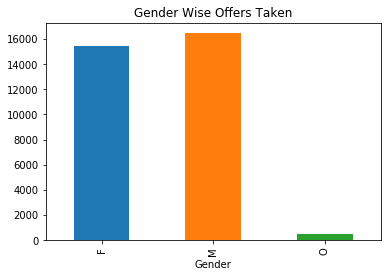

In [47]:
#visualizing how the different genders take and complete the offers from the app
user_gender_dist = gender_based_taken.plot.bar(title='Gender Wise Offers Taken')
user_gender_dist.set_xlabel("Gender")

As clearly depicted in the Graph there is not much difference between different genders.

The offers should be sent equally among all the genders, as the data represents 50% Males and 48% females take the offer.
Hence it should be sent to all of the users equally, irrespective of their gender.

Moving forward, Trying to do the same type of distribution for Income Based patters.

#### Income Based distribution 

Text(0.5,0,'Income')

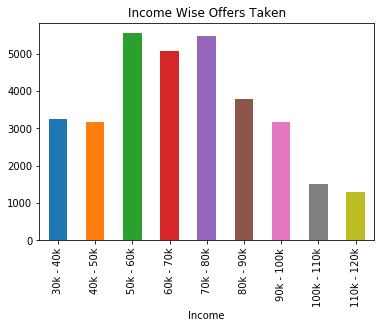

In [48]:
#defining age wise distribution for the offers taken
income_cols = ['30k - 40k','40k - 50k', '50k - 60k', '60k - 70k', '70k - 80k', '80k - 90k', '90k - 100k', '100k - 110k', '110k - 120k']
income_offer_taken = df[df['offer completed']==1][income_cols].sum()

#plot for income wise distribution for the offers taken
income_offer_taken_dist = income_offer_taken.plot.bar(title='Income Wise Offers Taken')
income_offer_taken_dist.set_xlabel("Income")



In [49]:
((df[df['offer completed']==1][income_cols].sum())/taken) * 100

30k - 40k      10.041918
40k - 50k       9.783011
50k - 60k      17.087905
60k - 70k      15.630009
70k - 80k      16.878313
80k - 90k      11.700160
90k - 100k      9.807669
100k - 110k     4.684996
110k - 120k     4.016151
dtype: float64

As depicted by the bar chart as well, most of the offers are availed by 50k-60k income people.
It is very close with income slabs of 60k-80k.

#### Age wise distribution

Text(0.5,0,'Age Groups')

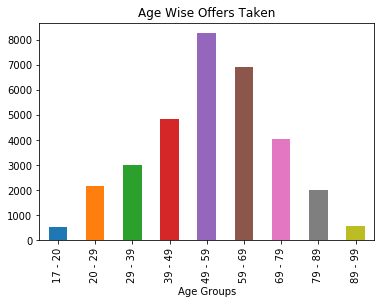

In [50]:
#age wise distribution for the offers availed
age_cols = ['17 - 20', '20 - 29', '29 - 39', '39 - 49', '49 - 59', '59 - 69', '69 - 79', '79 - 89', '89 - 99']
age_wise_offers_taken = df[df['offer completed']==1][age_cols].sum()
age_wise_offers_taken_dist = age_wise_offers_taken.plot.bar(title='Age Wise Offers Taken')
age_wise_offers_taken_dist.set_xlabel('Age Groups')

In [51]:
#percentage wise Breakdown
((df[df['offer completed']==1][age_cols].sum())/taken)*100

17 - 20     1.652077
20 - 29     6.688448
29 - 39     9.274442
39 - 49    14.976575
49 - 59    25.496240
59 - 69    21.310566
69 - 79    12.489212
79 - 89     6.173715
89 - 99     1.800025
dtype: float64

As depicted by the data above, most of the users which are aactually availing and using these offers belong to the age groups of 39-79.

**It would be better if more offers are sent to those age groups users**

Now we have looked into user characteristics, lets check how different types of offers can change the users mind whether to complete the offer or not.

Text(0.5,0,'Offers Validity')

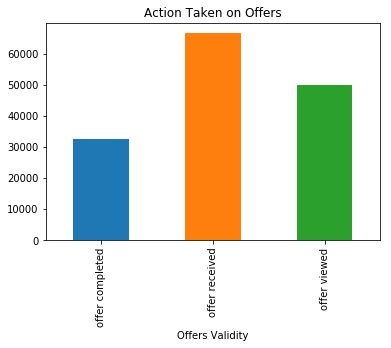

In [52]:
#offers wise distribution
#this contains how many offers received, how many were viewed and then completed
offers_dist = df[['offer completed', 'offer received', 'offer viewed']].sum()
offers_dist_gr = offers_dist.plot.bar(title='Action Taken on Offers')
offers_dist_gr.set_xlabel('Offers Validity')

We can clearly see there is a degression from offers viewed to completed.
Lets put them in graphs so its for us to understand them based on What kind of offers users are receiving

Mainly Users are receiving 3 types of offers:
- BOGO (Buy One Get One)
- Discount
- Informtional

Below i have tried to check of all the offer types, which offers are viewed the most on receiving and completed the most as well

Text(0.5,0,'Offer Type')

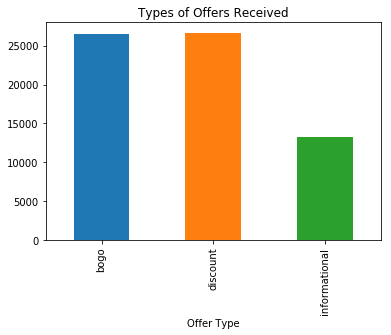

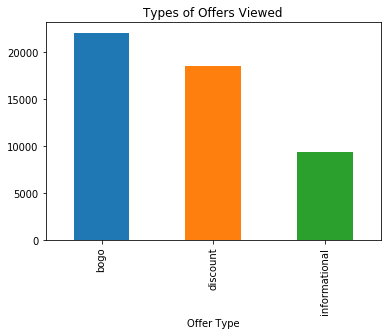

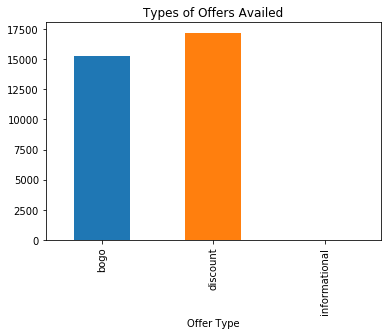

In [53]:
#types of offers viewed
offers_types = df[df['offer received']==1][['bogo', 'discount', 'informational']].sum()
offers_types_dist = offers_types.plot.bar(title='Types of Offers Received')
offers_types_dist.set_xlabel('Offer Type')

#types of offers viewed
plt.figure()
offers_types = df[df['offer viewed']==1][['bogo', 'discount', 'informational']].sum()
offers_types_dist = offers_types.plot.bar(title='Types of Offers Viewed')
offers_types_dist.set_xlabel('Offer Type')

#types of offers availed
plt.figure()
offers_type = df[df['offer completed']==1][['bogo', 'discount', 'informational']].sum()
offers_type_dist = offers_type.plot.bar(title='Types of Offers Availed')
offers_type_dist.set_xlabel('Offer Type')

In [54]:
(offers_type/df[df['offer completed']==1].shape[0])*100

bogo             47.028726
discount         52.971274
informational     0.000000
dtype: float64

It is clear form the data above that no user is using the informational data.

Everyone is clearly using the BOGO and Discount Offers.

**It Would be much better choice to stop sending informational offers (or atleast very minimal number of offers) and instead send more of BOGO and discount offers as the users are more inclined to avail those offers.**

Breaking down these offers received and completed further on all three.

In following steps, i am trying to see which kind of offers are most viewed and most completed.
Since informational offers are not even completed, so just going to see how much proporionally users view such offers.

In [55]:
#deeping further down on the offers availed, based on offers viewed and received
r = df[df['offer received']==1].shape[0]
v = df[df['offer viewed']==1].shape[0]
c = df[df['offer completed']==1].shape[0]

print('The percentage of offers viewed after receiving: {:.2f}'.format((v/r)*100))
print('The percentage of offers completed after receiving: {:.2f}'.format((c/r)*100))
print('The percentage of offers completed after viewing: {:.2f}'.format((c/v)*100))

The percentage of offers viewed after receiving: 74.98
The percentage of offers completed after receiving: 48.79
The percentage of offers completed after viewing: 65.07


In [56]:
#since only bogo and discount offers are taken, looking futher how many such offers were viewed and how many were completed
print("BOGO Offers First:")
b_r = df[df['offer received']==1]['bogo'].sum()
b_v = df[df['offer viewed']==1]['bogo'].sum()
b_c = df[df['offer completed']==1]['bogo'].sum()
                                   
print('The percentage of BOGO offers viewed after receiving: {:.2f}'.format((b_v/b_r)*100))
print('The percentage of BOGO offers completed after receiving: {:.2f}'.format((b_c/b_r)*100))
                                 

BOGO Offers First:
The percentage of BOGO offers viewed after receiving: 83.05
The percentage of BOGO offers completed after receiving: 57.50


In [57]:
#since only bogo and discount offers are taken, looking futher how many such offers were viewed and how many were completed
print("Discount Offers Now:")
d_r = df[df['offer received']==1]['discount'].sum()
d_v = df[df['offer viewed']==1]['discount'].sum()
d_c = df[df['offer completed']==1]['discount'].sum()
                                   
print('The percentage of discount offers viewed after receiving: {:.2f}'.format((d_v/d_r)*100))
print('The percentage of discount offers completed after receiving: {:.2f}'.format((d_c/d_r)*100))
                                  

Discount Offers Now:
The percentage of discount offers viewed after receiving: 69.24
The percentage of discount offers completed after receiving: 64.45


In [57]:
print("Discount Offers Now:")
i_r = df[df['offer received']==1]['informational'].sum()
i_v = df[df['offer viewed']==1]['informational'].sum()
i_c = df[df['offer completed']==1]['informational'].sum()

print('Total offers received for informational: {}'.format(i_r))
print('Total offers viewed for informational: {}'.format(i_v))
print('Total offers completed for informational: {}'.format(i_c))
print('The percentage of informational offers viewed after receiving: {:.2f}'.format((i_v/i_r)*100))



Discount Offers Now:
Total offers received for informational: 13300
Total offers viewed for informational: 9360
Total offers completed for informational: 0
The percentage of informational offers viewed after receiving: 70.38


### Effective Offers
After checking how BOGO and discount offers are availed, it is shown by the data more BOGO offers are viewed than discounted offers.

Clearly, BOGO offers are viewed much more than discount offers, so it can be a good option to send BOGO offers more.

But just viewing the offers shouldn't be the only criteria, as completing the offers is also a major part of the exercise of sending the users all these offers.

More discounted offers are availed (64%) than Bogo offers(57%), after viewing the offer.

So, given both the factors, both the offers should be sent out equally, with minimal number of informational as they are not completed at all. 

Some might even decide to stop the informational offers all together to promote the BOGO and discount offers more.

## Conclusion For Business Questions


Since we are done with most of our analysis for the business questions that we raised at the beginning, let's summarize all those findings together below

### Business Questions Findings:

#### What proportions of the users complete the offers based on their age and gender
This is actually broken down in the 3 main characteristics of the users:
- Age:
    - There is a clear pattern of the users trying to complete the offers
    - Users in the age groups of 39-79 years completes the most offers
    - age groups of 49-59 are the ones completing the highest number of offers, so more offers can be sent to them
- Gender:
    - There is no clear indication if males or females completes the offer more than the other
    - The offers should be Sent equally
- Income:
    - There are no clear outliers for which income group completes the most offers
    - The income regions of 50k-80k completes more offers than others
    
#### What kind of offers should be sent more to the users
This can be broken down on 3 types.
- Type:
    - Informational offers are not completed at all by any of the users, so even if they are not sent to the users, it won't impact the revenue
    - BOGO And discount offers should be sent equally, where BOGO are viewed more by the users and discount is completed more by the users on viewing the offer.

### Model Building and Implementation

In this section, i have tried to apply the Random Forest Classifier on the dataframe to check for the accuracy of the predictions.
It will give us indicator of the quality of the final data frame that we are using.

In [58]:
df.head(5)

,event,user_id,time,offer_id,offer completed,offer received,offer viewed,transaction,difficulty,duration,...,50k - 60k,60k - 70k,70k - 80k,80k - 90k,90k - 100k,100k - 110k,110k - 120k,F,M,O
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,7,...,0,0,0,0,1,0,0,1,0,0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1,0,5,7,...,0,0,0,0,1,0,0,1,0,0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,0,0,0,5,7,...,0,0,0,0,1,0,0,1,0,0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,5,5,...,0,0,0,0,1,0,0,1,0,0
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,f19421c1d4aa40978ebb69ca19b0e20d,1,0,0,0,5,5,...,0,0,0,0,1,0,0,1,0,0


In [59]:
df_final = df.drop(['event', 'user_id', 'time', 'offer_id', 'transaction', 'difficulty', 'duration', 'became_member_on'],axis=1)

In [60]:
df_final.head(5)

,offer completed,offer received,offer viewed,reward,email,mobile,social,web,bogo,discount,...,50k - 60k,60k - 70k,70k - 80k,80k - 90k,90k - 100k,100k - 110k,110k - 120k,F,M,O
0,0,1,0,5,1,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
1,0,0,1,5,1,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
2,1,0,0,5,1,1,0,1,1,0,...,0,0,0,0,1,0,0,1,0,0
3,0,1,0,5,1,1,1,1,1,0,...,0,0,0,0,1,0,0,1,0,0
4,1,0,0,5,1,1,1,1,1,0,...,0,0,0,0,1,0,0,1,0,0


In [61]:
X = df_final.drop(['offer completed'], axis=1)
Y = df_final['offer completed']

In [62]:
X.shape, Y.shape

((148805, 31), (148805,))

In [63]:
#splitting the dataset in the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [64]:
#defining classifier, using random forest as the main classifier
classifier = RandomForestClassifier()

In [65]:
# training the data
classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [66]:
# making the predictions on the test
y_pred = classifier.predict(X_test)

In [67]:
#checking the accuracy and retrieving classification report of the predictions using classifier
print("Accuracy:",accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     38465
          1       1.00      1.00      1.00     10641

avg / total       1.00      1.00      1.00     49106



In [68]:
print(f1_score(y_test, y_pred,  labels=None))

1.0
